In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.set_random_seed(1)
np.random.seed(1)#设置随机数

In [2]:
# Hyper Parameters
BATCH_SIZE = 64
LR_G = 0.0001           # learning rate for generator
LR_D = 0.0001           # learning rate for discriminator
N_IDEAS = 5             # think of this as number of ideas for generating an art work (Generator)
ART_COMPONENTS = 15     # it could be total point G can draw in the canvas

In [3]:
PAINT_POINTS=np.vstack([np.linspace(-1,1,ART_COMPONENTS) for _ in range(BATCH_SIZE)])#重复了15次
print PAINT_POINTS.shape

(64, 15)


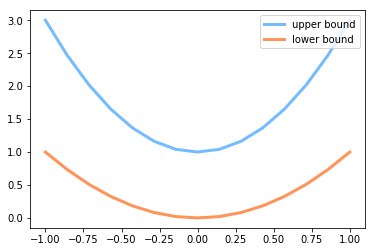

In [4]:
plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
plt.legend(loc='upper right')
plt.show()

In [9]:
def artist_works():
    a=np.random.uniform(1,2,size=BATCH_SIZE)[:,np.newaxis]
    paintings=a*np.power(PAINT_POINTS,2)+(a-1)# 64*1  64*15
    return paintings

In [8]:
a=np.random.uniform(1,2,size=BATCH_SIZE)[:,np.newaxis]
print a.shape
paintings=a*np.power(PAINT_POINTS,2)+(a-1)# 64*1  64*15
print paintings.shape

(64, 1)
(64, 15)


In [6]:
b=np.random.uniform(1,2,12)
print b

[ 1.04995346  1.53589641  1.66379465  1.51488911  1.94459476  1.58655504
  1.90340192  1.1374747   1.13927635  1.80739129  1.39767684  1.1653542 ]


In [7]:
c=np.power(PAINT_POINTS,2)
print c.shape

(64, 15)


In [10]:
with tf.variable_scope("Generator"):#生成器函数
    G_in=tf.placeholder(tf.float32,[None,N_IDEAS])
    G_l1=tf.layers.dense(G_in,128,tf.nn.relu)#全连接层，并且用relu作为激活函数
    G_out=tf.layers.dense(G_l1,ART_COMPONENTS)

In [11]:
with tf.variable_scope("Discriminator"):
    real=tf.placeholder(tf.float32,[None,ART_COMPONENTS],name="real_in")
    D_lo=tf.layers.dense(real,128,tf.nn.relu,name="l")
    prob_artist0=tf.layers.dense(D_lo,1,tf.nn.sigmoid,name="out")#直接输出一个0,1分类的可能性，用sigmoid作为激活函数
    D_l1=tf.layers.dense(G_out,128,tf.nn.relu,name="l",reuse=True)#重复使用参数,并且用生成器的生成结果作为输入
    prob_artist1=tf.layers.dense(D_l1,1,tf.nn.sigmoid,name="out",reuse=True)#这里指的重复利用参数是什么意思？

In [13]:
D_loss=-tf.reduce_mean(tf.log(prob_artist0)+tf.log(1-prob_artist1))#公式，真实的分布，再加上1-生成的图像的分布
G_loss=tf.reduce_mean(tf.log(1-prob_artist1))
train_D=tf.train.AdamOptimizer(0.001).minimize(D_loss,var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope="Discriminator"))
#取出使用Discriminator下的所有可训练的变量
train_G=tf.train.AdamOptimizer(0.001).minimize(G_loss,var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope="Generator"))#记住是一个.
sess=tf.Session()
sess.run(tf.global_variables_initializer())

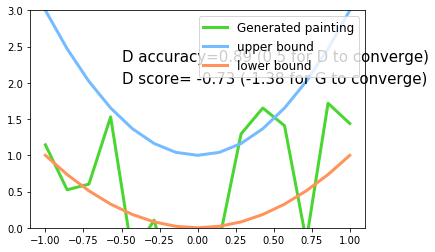

In [16]:
plt.ion()
for step in range(100):
    artist_paiting=artist_works()
    G_idea=np.random.randn(BATCH_SIZE,N_IDEAS)#输出标准正态分布的64 * 5的数据
    G_paintings,pa0,Dl=sess.run([G_out,prob_artist0,D_loss,train_D,train_G],
                                {G_in:G_idea,real:artist_paiting})[:3]#喂进数据，取生成的前三个数据
    if step % 50 == 0:  # plotting
        plt.cla()
        plt.plot(PAINT_POINTS[0], G_paintings[0], c='#4AD631', lw=3, label='Generated painting',)
        plt.plot(PAINT_POINTS[0], 2 * np.power(PAINT_POINTS[0], 2) + 1, c='#74BCFF', lw=3, label='upper bound')
        plt.plot(PAINT_POINTS[0], 1 * np.power(PAINT_POINTS[0], 2) + 0, c='#FF9359', lw=3, label='lower bound')
        plt.text(-.5, 2.3, 'D accuracy=%.2f (0.5 for D to converge)' % pa0.mean(), fontdict={'size': 15})
        plt.text(-.5, 2, 'D score= %.2f (-1.38 for G to converge)' % -Dl, fontdict={'size': 15})
        plt.ylim((0, 3)); plt.legend(loc='upper right', fontsize=12); plt.draw(); plt.pause(0.01)
plt.ioff()
plt.show()

In [17]:
artist_paiting=artist_works()
G_idea=np.random.randn(BATCH_SIZE,N_IDEAS)#输出标准正态分布的64 * 5的数据
G_paintings,pa0,Dl=sess.run([G_out,prob_artist0,D_loss,train_D,train_G],
                                {G_in:G_idea,real:artist_paiting})[:3]#喂进数据
print G_paintings.shape #G_paintings是生成的数据，在这里有64的样本
print pa0#生成的正确率 取64个样本的平均值正确率
print Dl

(64, 15)
[[ 0.43393546]
 [ 0.61247742]
 [ 0.67094928]
 [ 0.49222705]
 [ 0.68736994]
 [ 0.68384886]
 [ 0.61288172]
 [ 0.56589079]
 [ 0.49066323]
 [ 0.67664665]
 [ 0.7074725 ]
 [ 0.4946945 ]
 [ 0.63442528]
 [ 0.6429823 ]
 [ 0.5392614 ]
 [ 0.51730162]
 [ 0.681678  ]
 [ 0.42675936]
 [ 0.48313749]
 [ 0.68430007]
 [ 0.58425629]
 [ 0.65696943]
 [ 0.66634023]
 [ 0.41855294]
 [ 0.41880104]
 [ 0.70441574]
 [ 0.64604038]
 [ 0.7022326 ]
 [ 0.61207932]
 [ 0.40794399]
 [ 0.64614916]
 [ 0.68774098]
 [ 0.5958612 ]
 [ 0.67179716]
 [ 0.55767792]
 [ 0.47101507]
 [ 0.53303695]
 [ 0.55751216]
 [ 0.67381299]
 [ 0.43322834]
 [ 0.48429197]
 [ 0.41431731]
 [ 0.45562524]
 [ 0.43706027]
 [ 0.58684462]
 [ 0.64395583]
 [ 0.43515497]
 [ 0.67577404]
 [ 0.63904428]
 [ 0.62083417]
 [ 0.55922371]
 [ 0.70948541]
 [ 0.44123062]
 [ 0.70238453]
 [ 0.70949578]
 [ 0.54494286]
 [ 0.58516496]
 [ 0.69375521]
 [ 0.61321402]
 [ 0.50159001]
 [ 0.46019039]
 [ 0.61328447]
 [ 0.64018571]
 [ 0.61281729]]
1.13145
